Gaussian Mixture Model (GMM) ile Sentetik Muhabbet Kuşu Ceresi Üretimi
Bu çalışmada, gerçek muhabbet kuşu ceresi verilerinden yola çıkarak, Gaussian Mixture Model (GMM) kullanarak sentetik veri üretimi yapılmaktadır. GMM, verinin farklı alt gruplarını (bileşenlerini) temsil eden birden fazla Gauss dağılımının karışımıdır. Bu model sayesinde, karmaşık ve çok modlu veri dağılımlarını etkili şekilde modelleyebiliriz.

Amacımız, elimizdeki gerçek ceres verisinden öğrenerek, benzer özelliklere sahip yeni, sentetik cereler oluşturmaktır. Böylece veri setimizi çoğaltabilir, model eğitimi ve analizler için daha zengin ve çeşitli veri elde edebiliriz. Bu yöntem, biyolojik çeşitliliği ve doğal varyasyonu yakalayarak, gerçekçi ve anlamlı sentetik örnekler oluşturur.

GMM tabanlı sentetik veri üretimi, özellikle sınırlı sayıda gerçek veri olduğunda veya veri artırma (data augmentation) gerektiğinde etkili bir yaklaşımdır. Böylece, araştırmalarımızda daha sağlam ve genellenebilir sonuçlar elde etmemize olanak sağlar.

In [ ]:
!pip install scikit-image


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving dataset1.zip to dataset1.zip


In [ ]:
import zipfile
import os

zip_path = 'dataset1.zip'  # örneğin: 'budgie_dataset.zip'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('dataset')

# Klasör içeriğini görmek için
os.listdir('dataset')

['dataset']

In [ ]:
import os
import cv2

# Bir resmi ve ona ait YOLO formatındaki koordinat dosyasını alarak, belirtilen bölgeyi kırpıp yeni klasöre kaydeder
def crop_and_save(img_path, txt_path, save_path):
    img = cv2.imread(img_path)  # Görseli oku
    if img is None: return  # Görsel yoksa işlemi geç

    h, w = img.shape[:2]  # Görselin yüksekliği ve genişliği
    with open(txt_path) as f:
        _, x, y, bw, bh = map(float, f.readline().split())  # YOLO formatındaki bbox verisini oku

    # BBox koordinatlarını piksel cinsinden hesapla
    x1, y1 = int((x - bw/2) * w), int((y - bh/2) * h)
    x2, y2 = int((x + bw/2) * w), int((y + bh/2) * h)

    # Belirtilen bölgeyi kırp ve kaydet
    cv2.imwrite(save_path, img[y1:y2, x1:x2])

# Ana işlem
dataset_path = "/content/dataset/dataset"  # Ana veri kümesi klasör yolu
save_path = "cropped_dataset"              # Kırpılmış görsellerin kaydedileceği klasör

# Cinsiyet klasörleri (erkek ve dişi) için döngü başlat
for gender in ["erkek", "disi"]:
    os.makedirs(f"{save_path}/{gender}", exist_ok=True)  # Klasör yoksa oluştur

    # Her .jpg dosyasını işle
    for img_file in os.listdir(f"{dataset_path}/{gender}"):
        if img_file.endswith(".jpg"):
            img_p = f"{dataset_path}/{gender}/{img_file}"        # Görsel dosya yolu
            txt_p = img_p.replace(".jpg", ".txt")                # İlgili .txt dosya yolu
            if os.path.exists(txt_p):                            # .txt dosyası varsa işlem yap
                crop_and_save(img_p, txt_p, f"{save_path}/{gender}/{img_file}")


In [ ]:
# Belirtilen klasördeki "erkek" ve "disi" alt klasörlerinde bulunan .jpg uzantılı görsellerin toplam sayısını döndürür
def count_images(folder):
    count = 0
    for cls in ["erkek", "disi"]:
        class_path = os.path.join(folder, cls)
        count += len([f for f in os.listdir(class_path) if f.endswith(".jpg")])
    return count

# Kırpılmış görsellerin bulunduğu klasördeki toplam görsel sayısını hesapla
original_count = count_images("cropped_dataset")
print(f"GMM öncesi toplam görsel sayısı: {original_count}")



GMM öncesi toplam görsel sayısı: 1177


In [ ]:
from sklearn.mixture import GaussianMixture
import numpy as np
import cv2
import os
import random

def generate_synthetic_for_random_samples(source_folder, save_folder, n_samples=20, img_size=(32, 32)):
    os.makedirs(save_folder, exist_ok=True)

    all_files = [f for f in os.listdir(source_folder) if f.endswith('.jpg')]

    # Klasörden rastgele seçilen n_samples görsel
    selected_files = random.sample(all_files, min(n_samples, len(all_files)))

    for filename in selected_files:
        img_path = os.path.join(source_folder, filename)
        img = cv2.imread(img_path)
        img = cv2.resize(img, img_size)
        flat_img = img.flatten() / 255.0


        gmm = GaussianMixture(n_components=1, covariance_type='full', random_state=42)
        # Aynı tek görseli 2 kere vererek GMM fit et
        gmm.fit([flat_img, flat_img])

        # Bu görsele özgü 1 sentetik görsel üret
        synth_flat = gmm.sample(1)[0][0]
        synth_flat = np.clip(synth_flat * 255, 0, 255).astype(np.uint8)
        synth_img = synth_flat.reshape(*img_size, 3)

        synth_name = f"synth_{os.path.splitext(filename)[0]}.jpg"
        cv2.imwrite(os.path.join(save_folder, synth_name), synth_img)


# Klasör ayarları
gmm_augmented_path = "cropped_dataset_augmented4"

for cls in ["erkek", "disi"]:
    class_source = os.path.join("cropped_dataset", cls)
    class_target = os.path.join(gmm_augmented_path, cls)
    os.makedirs(class_target, exist_ok=True)

    # Orijinal görselleri kopyala
    for f in os.listdir(class_source):
        if f.endswith('.jpg'):
            img = cv2.imread(os.path.join(class_source, f))
            cv2.imwrite(os.path.join(class_target, f), img)

    # Rastgele seçilen 20 görselden her birine özgü 1 sentetik görsel üret
    generate_synthetic_for_random_samples(class_source, class_target, n_samples=20)


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def compare_images_readably(real_folder, synth_folder, pairs):
    for real_name, synth_name in pairs:
        real_path = os.path.join(real_folder, real_name)
        synth_path = os.path.join(synth_folder, synth_name)

        if not os.path.exists(real_path):
            print(f"[HATA] Gerçek görsel bulunamadı: {real_name}")
            continue
        if not os.path.exists(synth_path):
            print(f"[HATA] Sentetik görsel bulunamadı: {synth_name}")
            continue

        real_img = cv2.imread(real_path)
        synth_img = cv2.imread(synth_path)

        h, w = real_img.shape[:2]
        if synth_img.shape != real_img.shape:
            synth_img = cv2.resize(synth_img, (w, h))

        # Parlaklık
        real_gray = cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY)
        synth_gray = cv2.cvtColor(synth_img, cv2.COLOR_BGR2GRAY)
        real_brightness = np.mean(real_gray)
        synth_brightness = np.mean(synth_gray)
        brightness_diff = abs(real_brightness - synth_brightness)

        # Renk farkları (ortalama her kanal için)
        real_r = np.mean(real_img[:, :, 2])
        synth_r = np.mean(synth_img[:, :, 2])
        diff_r = abs(real_r - synth_r)

        real_g = np.mean(real_img[:, :, 1])
        synth_g = np.mean(synth_img[:, :, 1])
        diff_g = abs(real_g - synth_g)

        real_b = np.mean(real_img[:, :, 0])
        synth_b = np.mean(synth_img[:, :, 0])
        diff_b = abs(real_b - synth_b)

        # MSE
        mse = np.mean((real_img.astype("float") - synth_img.astype("float")) ** 2)

        # Fark görseli
        diff_img = cv2.absdiff(real_img, synth_img)

        print(f"\nKarşılaştırma: {real_name} ile {synth_name}")
        print(f" Görsel Boyutu: {h} x {w} (yükseklik x genişlik)\n")

        print(f" Parlaklık:")
        print(f"   - Orijinal Görsel Parlaklığı (Gri ortalama): {real_brightness:.2f}")
        print(f"   - Sentetik Görsel Parlaklığı: {synth_brightness:.2f}")
        print(f"   -> Aradaki Fark: {brightness_diff:.2f}\n")

        print(f" Renk Ortalamaları (0-255 arası):")
        print(f"   - Kırmızı (R): Orijinal={real_r:.2f} | Sentetik={synth_r:.2f} | Fark={diff_r:.2f}")
        print(f"   - Yeşil (G):   Orijinal={real_g:.2f} | Sentetik={synth_g:.2f} | Fark={diff_g:.2f}")
        print(f"   - Mavi (B):    Orijinal={real_b:.2f} | Sentetik={synth_b:.2f} | Fark={diff_b:.2f}\n")

        print(f" MSE (Ortalama Kare Hata): {mse:.2f}")
        print("    Bu değer ne kadar yüksekse, görseller arasındaki fark o kadar büyük demektir.\n")

        # Görsel gösterimi
        plt.figure(figsize=(10, 5))
        plt.suptitle(f"Gerçek Görsel: {real_name} | Sentetik: {synth_name}", fontsize=13)

        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB))
        plt.title("Orijinal Görsel")
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(synth_img, cv2.COLOR_BGR2RGB))
        plt.title("Sentetik Görsel")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

        # Farkları göster
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(diff_img, cv2.COLOR_BGR2RGB))
        plt.title("Görseller Arasındaki Fark")
        plt.axis('off')
        plt.show()



🔍 img86.jpg vs synth_img86.jpg
-----------------------
MSE: 16.1 | PSNR: 35.8 dB | SSIM: 0.980
Renk Farkları (B/G/R):
  - Mavi: 0.9
  - Yeşil: 0.7
  - Kırmızı: 0.8
 Kenar Farkı: 21.3


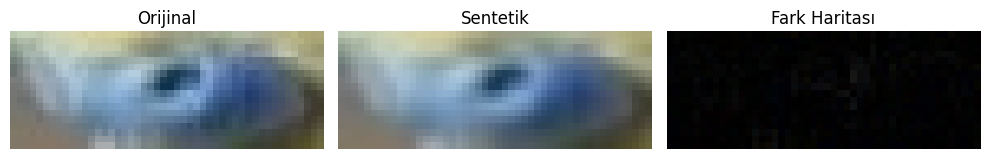

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage.metrics import structural_similarity as ssim

def compare_images_simple(real_folder, synth_folder, pairs):
    for real_name, synth_name in pairs:
        real_path = os.path.join(real_folder, real_name)
        synth_path = os.path.join(synth_folder, synth_name)

        # Dosya kontrolü
        if not os.path.exists(real_path):
            print(f"[HATA] Gerçek görsel yok: {real_name}")
            continue
        if not os.path.exists(synth_path):
            print(f"[HATA] Sentetik görsel yok: {synth_name}")
            continue

        # Görselleri yükle
        real_img = cv2.imread(real_path)
        synth_img = cv2.imread(synth_path)

        # Boyutları eşitle
        h, w = real_img.shape[:2]
        synth_img = cv2.resize(synth_img, (w, h))

        # 1. TEMEL METRİKLER
        mse = np.mean((real_img - synth_img) ** 2)
        psnr = cv2.PSNR(real_img, synth_img)
        ssim_score = ssim(cv2.cvtColor(real_img, cv2.COLOR_BGR2GRAY),
                         cv2.cvtColor(synth_img, cv2.COLOR_BGR2GRAY))

        # 2. RENK FARKLARI (Ortalama BGR)
        real_b, real_g, real_r = np.mean(real_img, axis=(0,1))
        synth_b, synth_g, synth_r = np.mean(synth_img, axis=(0,1))

        # 3. KENAR FARKI (Basit Canny)
        real_edges = cv2.Canny(real_img, 100, 200)
        synth_edges = cv2.Canny(synth_img, 100, 200)
        edge_diff = np.mean(np.abs(real_edges - synth_edges))

        # Sonuçları göster
        print(f"\n🔍 {real_name} vs {synth_name}")
        print("-----------------------")
        print(f"MSE: {mse:.1f} | PSNR: {psnr:.1f} dB | SSIM: {ssim_score:.3f}")
        print(f"Renk Farkları (B/G/R):")
        print(f"  - Mavi: {abs(real_b-synth_b):.1f}")
        print(f"  - Yeşil: {abs(real_g-synth_g):.1f}")
        print(f"  - Kırmızı: {abs(real_r-synth_r):.1f}")
        print(f" Kenar Farkı: {edge_diff:.1f}")

        # Görsel karşılaştırma
        plt.figure(figsize=(10, 4))

        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB))
        plt.title("Orijinal")
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(synth_img, cv2.COLOR_BGR2RGB))
        plt.title("Sentetik")
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(cv2.absdiff(real_img, synth_img)[:, :, ::-1])
        plt.title("Fark Haritası")
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Kullanım
real_folder = "cropped_dataset/erkek"
synth_folder = "cropped_dataset_augmented4/erkek"

image_pairs = [
    ("img86.jpg", "synth_img86.jpg"),
]

compare_images_simple(real_folder, synth_folder, image_pairs)

📊 SSIM (Structural Similarity Index Measure) ve PSNR (Peak Signal-to-Noise Ratio)
Görüntü kalitesini değerlendirmek için kullanılan iki önemli metriktir: PSNR ve SSIM. İşte detaylı açıklamaları ve farkları:

🧮 1. PSNR (Tepe Sinyal-Gürültü Oranı)
Ne Ölçer?
Görüntüler arasındaki piksel bazlı hataları ölçer (özellikle sıkıştırma veya gürültü kaynaklı bozulmalar).

Hesaplama:
PSNR, MSE (Mean Squared Error) kullanılarak hesaplanır:

𝑃
𝑆
𝑁
𝑅
=
10
⋅
log
⁡
10
(
𝑀
𝐴
𝑋
𝐼
2
𝑀
𝑆
𝐸
)
PSNR=10⋅log
10
​
 (
MSE
MAX
I
2
​

​
 )
MAX_I: Maksimum piksel değeri (örneğin, 8-bit görüntüde 255)

MSE: Gerçek ve bozulmuş görüntü arasındaki ortalama kare farkı

Yorum:

Yüksek PSNR (örneğin 30 dB üstü) → Düşük hata, yüksek benzerlik

Ancak, insan gözünün algısıyla tam uyumlu değildir (örneğin, yüksek PSNR ama kötü görünen görüntü olabilir)

🧠 2. SSIM (Yapısal Benzerlik Endeksi)
Ne Ölçer?
Görüntülerin yapısal, parlaklık ve kontrast benzerliğini, insan algısına yakın şekilde değerlendirir.

𝑆
𝑆
𝐼
𝑀
(
𝑥
,
𝑦
)
=
𝑙
(
𝑥
,
𝑦
)
⋅
𝑐
(
𝑥
,
𝑦
)
⋅
𝑠
(
𝑥
,
𝑦
)
SSIM(x,y)=l(x,y)⋅c(x,y)⋅s(x,y)
l(x, y): Parlaklık karşılaştırması

c(x, y): Kontrast karşılaştırması

s(x, y): Yapısal benzerlik (gradyan, kenar gibi öğeler)

Yorum:

SSIM skoru 1.0 → Mükemmel eşleşme

0 → Hiç benzerlik yok

İnsan gözünün hassasiyetlerine daha uyumludur (özellikle kenar bozulmalarını daha iyi yakalar)

🔍 Temel Farklar
Özellik	PSNR	SSIM
Odak Noktası	Piksel seviyesinde hata	Yapısal ve algısal benzerlik
Hesaplama	MSE'ye dayalı (matematiksel)	İstatistiksel (yerel pencerelerle)
İnsan Algısı	Zayıf uyum	Güçlü uyum
Kullanım Senaryosu	Hızlı, basit karşılaştırma	Detaylı kalite analizi

🧪 Örnekteki Çıktıların Anlamı
MSE: 341.5 → Piksel başına ortalama kare farkı (ne kadar düşükse o kadar iyi)

PSNR: 22.8 dB → 20-30 dB arası genellikle orta seviye benzerlik

SSIM: 0.645 → 0.6-0.8 arası makul benzerlik, ama mükemmel değil

❓ Hangi Metrik Daha İyi?
PSNR hızlı ve basittir, ancak insan algısını yansıtmaz.

SSIM daha gerçekçi sonuçlar verir.
Özellikle tıbbi görüntüler, sanatsal çalışmalar ve algısal kalite değerlendirmeleri için SSIM tercih edilir.

